# Cloudy With a Chance of Football
## Global Machine Learning Model Part Two: Model Selection and Parameter Tuning
<a id='header_cell'></a>

Author: Aidan O'Connor   
Date: 20 June 2021   

<img src='https://static.clubs.nfl.com/image/private/t_editorial_landscape_12_desktop_2x/f_auto/cardinals/s43eajirdyxulvasrne2.jpg' alt="drawing" width="800"/> 
*Area of future study: do Quarterbacks who wear visors win Super Bowls? (photo courtesy of the [The Arizona Cardinals](https://www.azcardinals.com/news/cardinals-kyler-murray-might-get-his-in-game-tinted-visor-after-all))*

- [Importing packages, setting preferences, reading in data](#import_set_read_cell)
- [Understanding the data through visualizations](#data_review_cell)
- [Understanding the data through summary statistics](#data_review_summary_cell)
- [Preparing the data](#preparing_data_cell)
- [Global Machine Learning Model](#global_model_cell)
    - [Model Selection](#model_selection_cell)
        - [Selecting Columns](#column_selection_cell)
        - [Selecting models to score](#model_scoring_selection_cell)
        - [Scoring and visualizing selected models](#scoring_models_cell)
        - [Adding basic parameters to initial slate of models](#basic_parameter_tuning_cell)
        - [Setting aside the good models](#good_models_cell)
        - [Adjusting basic parameters of a few problem models](#basic_parameter_tuning_problem_models_cell)
        - [Further tuning parameters of good models](#further_tuning_good_models_cell)
    - [Grid Search](#grid_search_cell)
        - [Grid Searching the Support Vector Classifier](#svc_gridsearch_cell)
        - [Grid Searching the Stochastic Gradient Descent Classifier](#sdg_gridsearch_cell)
    - [Visualizing SDGClassifier Model Performance with a Confusion Matrix](#confusion_matrix_cell)
    - [Time Series Split Cross Validation](#time_series_split_cv)
    - [Pickling the Model for Future Use](#pickling_cell)

### Importing packages, setting preferences, reading in data
<a id='import_set_read_cell'></a>

In [97]:
# Packages to import and manipulate data
import pandas as pd
import numpy as np
import sqlite3
import pickle

# Packages to visualize data
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Packages to create and visualize machine learning models from yellowbrick
from yellowbrick.target import ClassBalance
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import confusion_matrix

# Packages to create machine learning models from scikit-learn
from sklearn.model_selection import train_test_split as tts
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import Ridge
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

#Evaluation toolset
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import KFold
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport

Set pandas viewing options, bringing in Jupyter magic, and set plt styling options

In [49]:
pd.set_option('display.max_columns', None)

%matplotlib inline

plt.rcParams['figure.figsize'] = (18,10)
plt.style.use('fivethirtyeight')

Read in the ```merged_df.csv``` exported during Part One

In [50]:
df = pd.read_csv('../../../fixtures/cleaned_data/merged_df.csv')

Open the connection to our database and merge the target variables with the merged dataframe

In [51]:
conn = sqlite3.connect('../../../fixtures/database/cloudy_with_a_chance_of_football.db')
cursorObj = conn.cursor()

target = pd.read_sql_query('SELECT * from performance_target',conn)

df = pd.merge(
    df,
    target,
    how = 'left',
    left_on = ['PlayerID','week_id','performance'],
    right_on = ['PlayerID','week_id','performance']
)

df

,GameKey,PlayerID,Season,Week,Team,Opponent,HomeOrAway,Position,PositionCategory,InjuryStatus,TeamID,OpponentID,ScoreID,week_id,OpponentRZ,days_since_last_game,absolute_hours_displaced,weather_temperature,weather_wind_mph_number,weather_wind_direction,weather_cloud_cover,weather_precipitation,weather_humidity,weather_detail,elevation_displacement,age,Played,Started,PassingAttempts,PassingCompletions,PassingYards,PassingCompletionPercentage,PassingYardsPerAttempt,PassingYardsPerCompletion,PassingTouchdowns,PassingInterceptions,PassingRating,PassingLong,PassingSacks,PassingSackYards,RushingAttempts,RushingYards,RushingYardsPerAttempt,RushingTouchdowns,RushingLong,ReceivingTargets,Receptions,ReceivingYards,ReceivingYardsPerReception,ReceivingTouchdowns,ReceivingLong,Fumbles,FumblesLost,PuntReturns,PuntReturnYards,PuntReturnTouchdowns,KickReturns,KickReturnYards,KickReturnTouchdowns,SoloTackles,AssistedTackles,TacklesForLoss,Sacks,SackYards,QuarterbackHits,PassesDefended,FumblesForced,FumblesRecovered,FumbleReturnTouchdowns,Interceptions,InterceptionReturnTouchdowns,FieldGoalsAttempted,FieldGoalsMade,ExtraPointsMade,TwoPointConversionPasses,TwoPointConversionRuns,TwoPointConversionReceptions,ExtraPointsAttempted,FieldGoalsMade0to19,FieldGoalsMade20to29,FieldGoalsMade30to39,FieldGoalsMade40to49,FieldGoalsMade50Plus,PointsAllowedByDefenseSpecialTeams,BlockedKickReturnTouchdowns,PointsAllowed,SpecialTeamsTouchdowns,DefensiveTouchdowns,BlockedKicks,TwoPointConversionReturns,FieldGoalReturnTouchdowns,Safeties,TouchdownsScored,PassingYardsRZ,PassingTouchdownsRZ,PassingInterceptionsRZ,RushingYardsRZ,RushingTouchdownsRZ,ReceptionsRZ,ReceivingYardsRZ,ReceivingTouchdownsRZ,SacksRZ,InterceptionsRZ,FumblesForcedRZ,FumlbesRecoveredRZ,performance,projected,actual,difference,performance_class
0,201910101,1,2019,1,ARZ,DET,HOME,DEF,DEF,0,1,11,16994,2019_1,0,365,0,72,0,No wind,0.39,0.0,0.32,DOME,0,25.354502,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.90,7.0,1.10,far overperformed
1,201910203,1,2019,2,ARZ,BLT,AWAY,DEF,DEF,0,1,3,17008,2019_2,0,7,2,81,3,North - NorthWest,0.00,0.0,0.45,Clear,3226593,25.354502,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,3.0,24.0,11.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0,0.0,27.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.40,2.0,-3.40,far underperformed
2,201910301,1,2019,3,ARZ,CAR,HOME,DEF,DEF,0,1,5,17024,2019_3,0,7,0,72,0,No wind,0.40,0.0,0.90,DOME,0,25.354502,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.5,2.0,14.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,0.0,23.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.00,0.0,-8.00,far underperformed
3,201910401,1,2019,4,ARZ,SEA,HOME,DEF,DEF,0,1,30,17041,2019_4,0,7,0,72,0,No wind,0.38,0.0,0.36,DOME,0,25.354502,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,21.0,4.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.0,0.0,38.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.70,4.0,-1.70,far underperformed
4,201910507,1,2019,5,ARZ,CIN,AWAY,DEF,DEF,0,1,7,17047,2019_5,0,7,2,76,6,West - SouthWest,0.87,0.0,0.60,Mostly Cloudy,1792624,25.354502,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,4.0,15.0,7.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

[reurn to top](#header_cell)
### Understanding the data through visualizations
<a id='data_review_cell'></a>

Let's begin by reviewing the performance of players every week with an eye towards the target variable

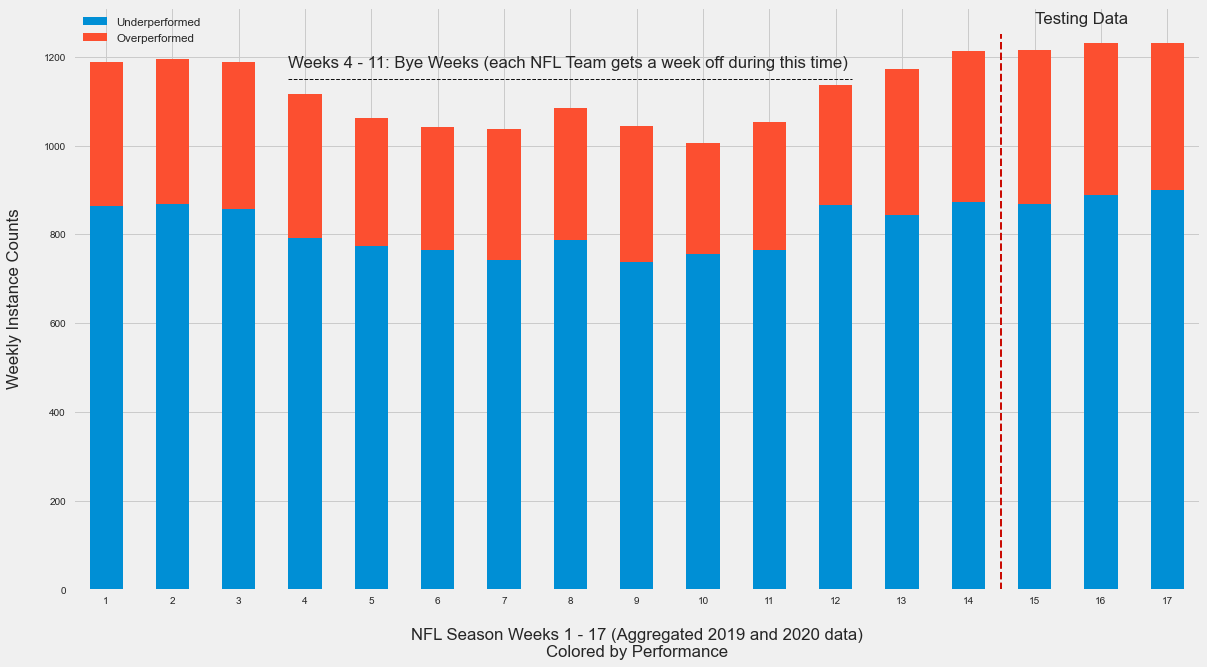

In [52]:
agg_df = df.groupby(['Week','performance'])['Week'].count().unstack().fillna(0)

agg_df.plot(kind = 'bar', stacked = True)
    
plt.xlabel(
    '\n'
    'NFL Season Weeks 1 - 17 (Aggregated 2019 and 2020 data)'
    '\n'
    'Colored by Performance'
)

plt.legend(
    ['Underperformed', 'Overperformed'],
    loc = 'upper left',
    fontsize = 'small'
)

plt.ylabel(
    'Weekly Instance Counts'
    '\n'
)

plt.text(
    2.75,
    1175,
    'Weeks 4 - 11: Bye Weeks (each NFL Team gets a week off during this time)',
    fontsize = 'large',
)

plt.plot(
    [
        2.75,
        11.25
    ],[
        1150,
        1150
    ],
    'k',
    lw = 1,
    linestyle = 'dashed'
)

plt.plot(
    [
        13.5,
        13.5
    ],[
        0,
        1250
    ],
    'r',
    lw = 2,
    linestyle = 'dashed'
)

plt.text(
    14,
    1275,
    'Testing Data',
    fontsize = 'large',
)

plt.xticks(rotation=0)

plt.yticks(rotation=0)

plt.savefig('../../../fixtures/images/presentation_screenshots/Global_WeeklyValueCountsAndPerformance_BarChart.png')

Next, I'll check out a rolling sum of weekly instances colored by performance

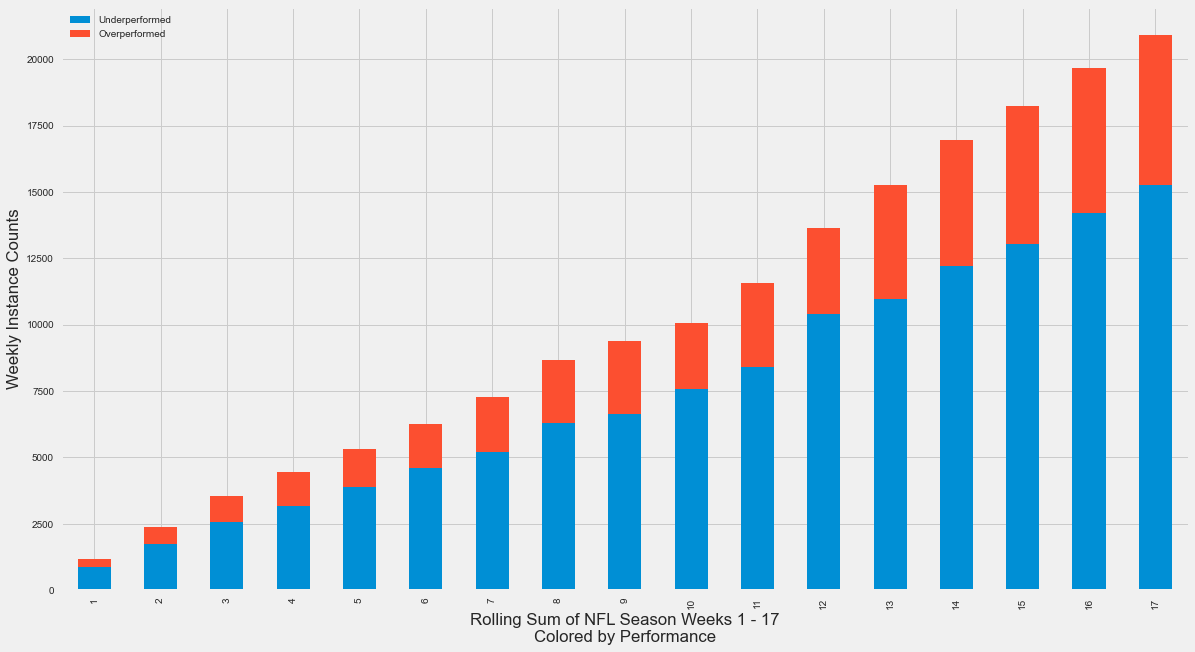

In [53]:
agg_df = df.groupby(['Week','performance'])['Week'].sum().unstack().fillna(0)

agg_df.plot(kind = 'bar', stacked = True)

plt.ylabel('Weekly Instance Counts')

plt.xlabel(
    'Rolling Sum of NFL Season Weeks 1 - 17'
    '\n'
    'Colored by Performance'
)

plt.legend(
    ['Underperformed', 'Overperformed'],
    loc = 'upper left'
)

plt.savefig('../../../fixtures/images/presentation_screenshots/Global_SummedWeeklyValueCountsAndPerformance_BarChart.png')

I'd also like to see the varying numbers of instances of positions and see the proportion of over and under performance

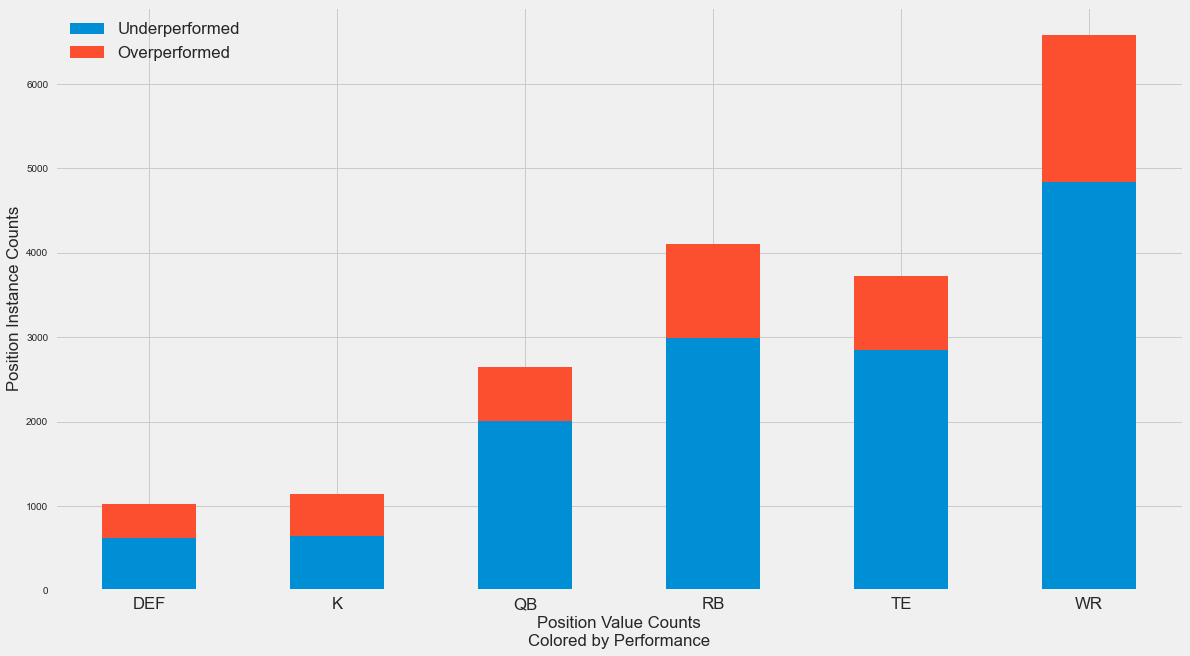

In [54]:
# Check out performance by week
agg_df = df.groupby(['Position','performance'])['Week'].count().unstack().fillna(0)

agg_df.plot(kind = 'bar',
            stacked = True
)

plt.ylabel(
    'Position Instance Counts',
    fontsize = 'large'
)

plt.xlabel(
    'Position Value Counts'
    '\n'
    'Colored by Performance',
    fontsize = 'large'
)

plt.legend(
    ['Underperformed', 'Overperformed'],
    loc = 'upper left',
    fontsize = 'large'
)

plt.xticks(
    rotation = 0,
    fontsize = 'large'
)

plt.yticks(rotation = 0)

plt.savefig(
    '../../../fixtures/images/presentation_screenshots/Global_PositionAndPerformanceValueCounts_BarChart.png',
    bbox_inches='tight'
)

Next, I'd like to see a scatterplot of all players with projected and actual performace colored by position to see if there are any position-based trends.

No handles with labels found to put in legend.


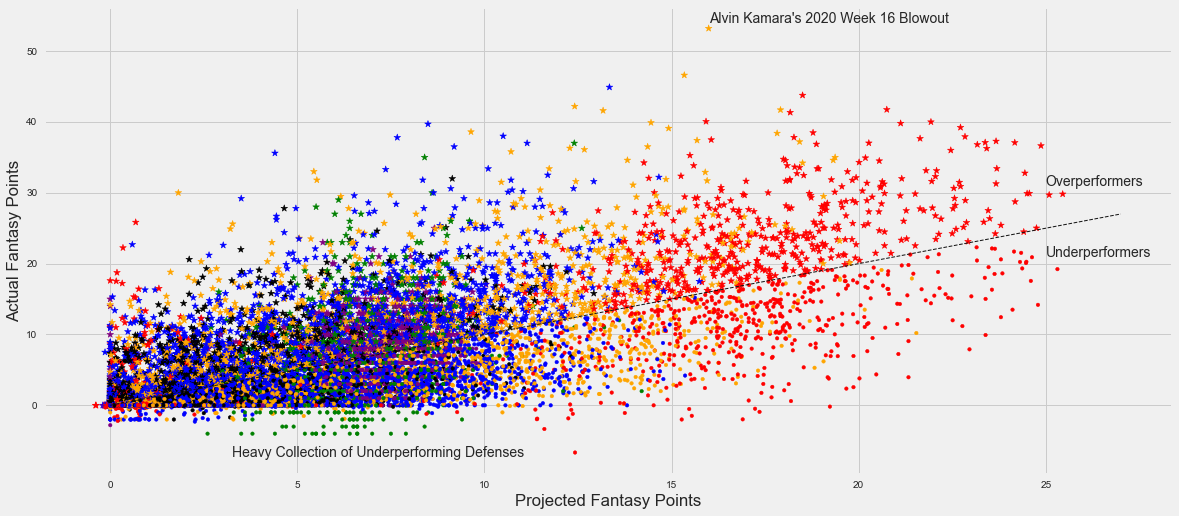

In [293]:
labels = list(df['Position'])

plt.rcParams['figure.figsize'] = (18,8)
plt.style.use('fivethirtyeight')

colors = {
    'DEF':'green',
    'WR':'blue',
    'QB':'red',
    'K':'purple',
    'TE':'black',
    'RB':'orange'
}

plt.scatter(
    df['projected'][df['performance'] == 1.0],
    df['actual'][df['performance'] == 1.0],
    c = df['Position'][df['performance'] == 1.0].map(colors),
    marker = '*'
)

plt.scatter(
    df['projected'][df['performance'] == 0.0],
    df['actual'][df['performance'] == 0.0],
    c = df['Position'][df['performance'] == 0.0].map(colors),
    marker = '.'
)

plt.plot(
    [
        0,
        27
    ],[
        0,
        27
    ],
    'k',
    lw = 1,
    linestyle = 'dashed'
)

plt.ylabel(
    'Actual Fantasy Points',
    fontsize  = 'large'
)

plt.xlabel(
    'Projected Fantasy Points',
    fontsize  = 'large'
)

plt.text(
    16,
    54,
    "Alvin Kamara's 2020 Week 16 Blowout"
)

plt.text(
    25,
    31,
    "Overperformers"
)

plt.text(
    25,
    21,
    "Underperformers"
)    

plt.text(
    3.25,
    -7.25,
    "Heavy Collection of Underperforming Defenses"
)

ax.legend()
ax.grid(True)

plt.savefig(
    '../../../fixtures/images/presentation_screenshots/Global_PlayersActualVersusProjected_Scatter.png',
    bbox_inches='tight'
)

plt.show()

Next, I'd like to see the relationships between non-stats columns and the delta between projected and actual scores.   

While this metric is not the target variable, it's a more helpful visualization than the binary target variable.   

You're still able to see the difference between over and under-performance by focusing on the x-axis at 0.   

The stats columns are so zero-heavy that scatterplots and box plots won't be helpful to view.

In [279]:
boxplot_and_scatter_cols = [
 'Week',
 'days_since_last_game',
 'absolute_hours_displaced',
 'weather_temperature',
 'weather_wind_mph_number',
 'weather_cloud_cover',
 'weather_precipitation',
 'weather_humidity',
 'age',
 'elevation_displacement'
]

View thes columns as histograms first

In [300]:
df['age'].mean()

26.50802755430785

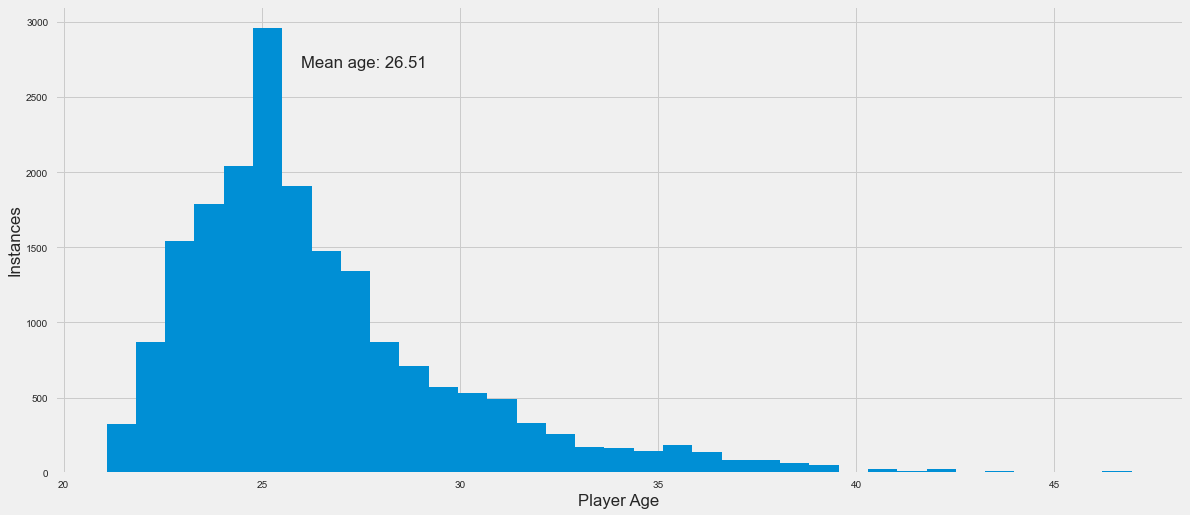

In [305]:
df['age'].hist(bins = 35)
plt.xlabel('Player Age')
plt.ylabel('Instances')
plt.text(
    26,
    2700,
    (f"Mean age: {round(df['age'].mean(),2)}"),
    fontsize = 'large'
)
plt.savefig(
    '../../../fixtures/images/presentation_screenshots/Global_InstancesOfPlayerAge_Histogram.png',
    bbox_inches='tight'
)

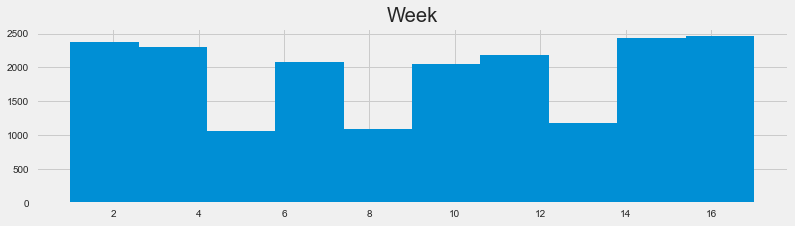

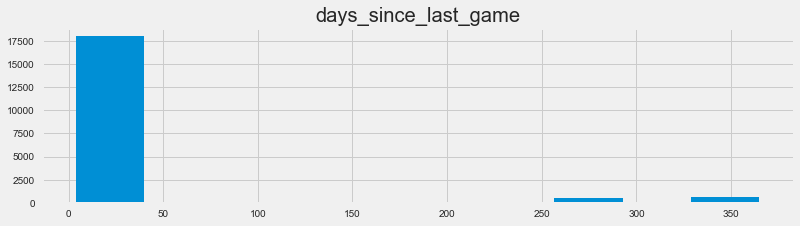

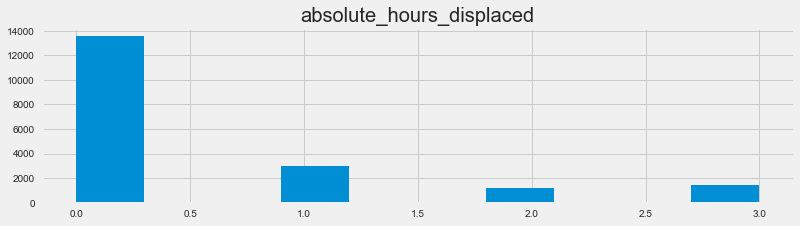

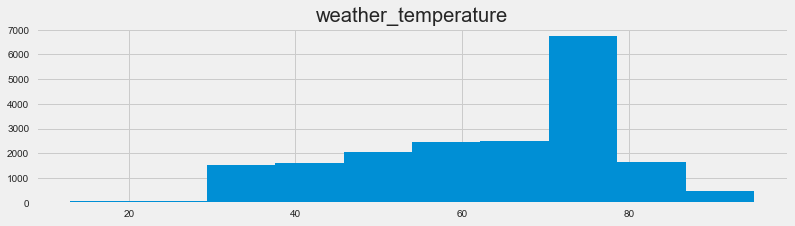

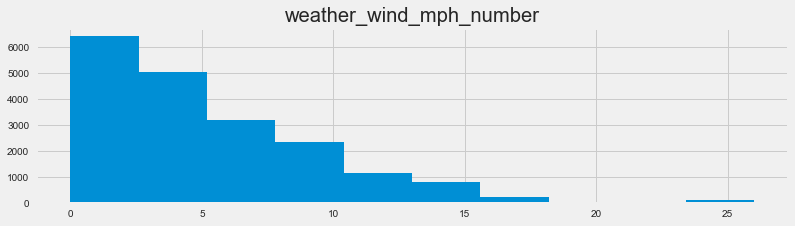

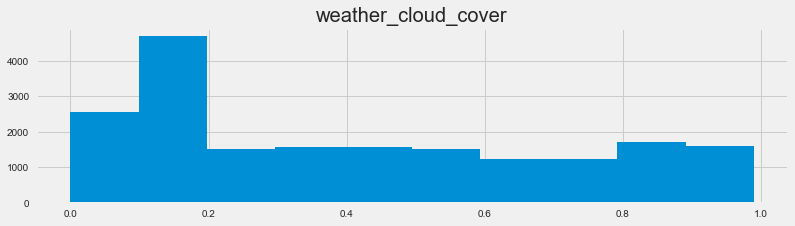

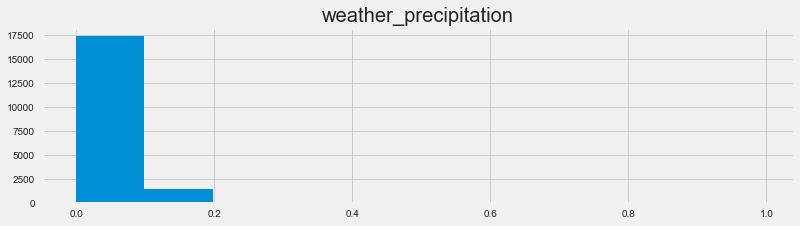

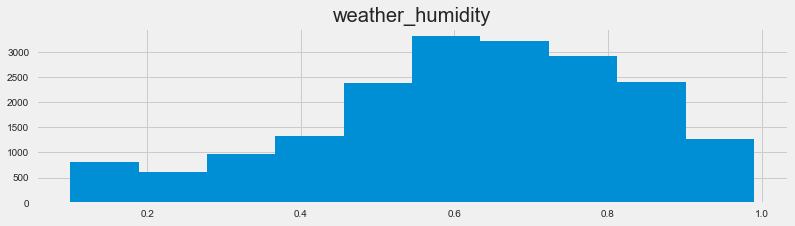

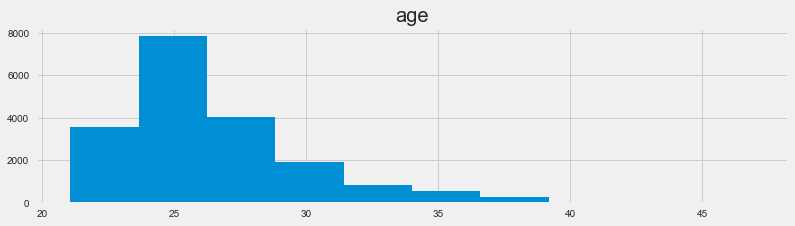

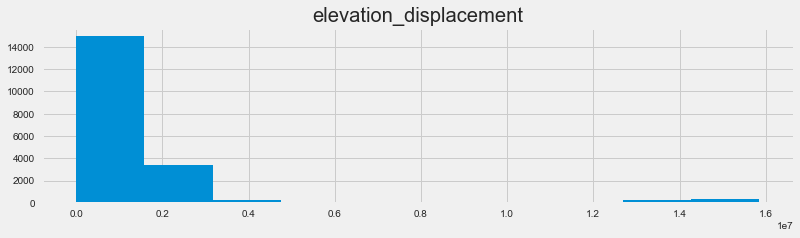

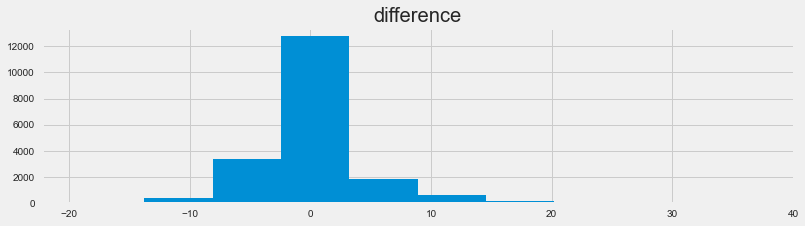

In [57]:
for col in boxplot_and_scatter_cols:
    
    df[col].hist(figsize = (12,3))
    plt.title(col)
    plt.show()
    
    plt.close()

Next, I'll look at these same columns in a scatterplot

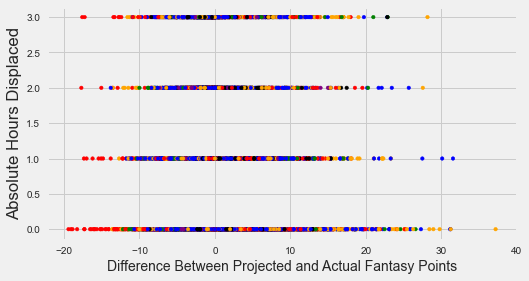

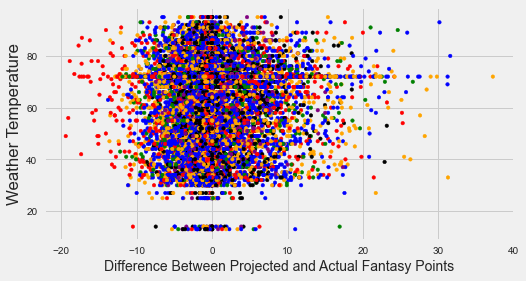

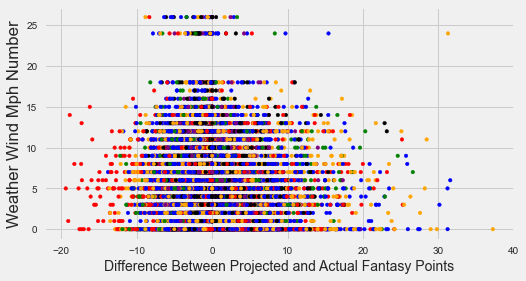

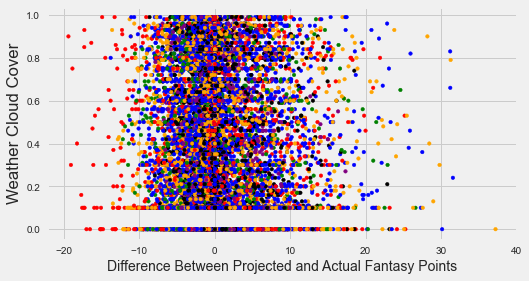

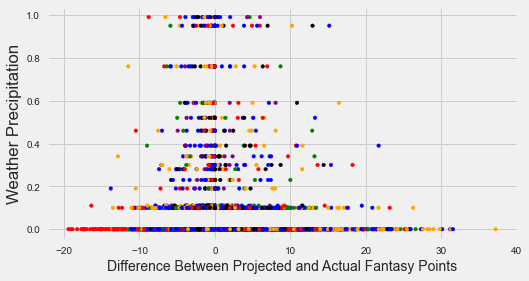

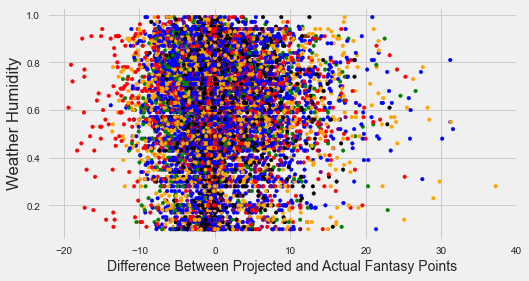

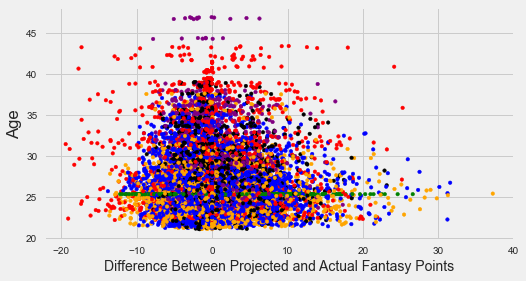

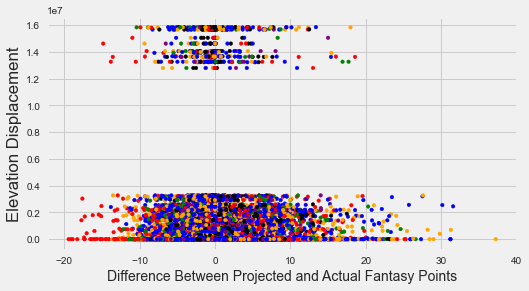

<Figure size 540x288 with 0 Axes>

In [285]:
colors = {
    'DEF':'green',
    'WR':'blue',
    'QB':'red',
    'K':'purple',
    'TE':'black',
    'RB':'orange'
}

for col in df[boxplot_and_scatter_cols].columns[2:len(df[boxplot_and_scatter_cols].columns)]:
    
    plt.rcParams['figure.figsize'] = (7.5,4)
    plt.style.use('fivethirtyeight')
    
    plt.ylabel(
        (f"{col.replace('_',' ').title()}"),
        fontsize  = 'large'
    )

    plt.xlabel(
        'Difference Between Projected and Actual Fantasy Points',
        fontsize  = 'medium'
    )
    
    plt.scatter(
        x = df['difference'],
        y = df[col],
        c = df['Position'].map(colors),
        marker = '.'
    
    )
    
    plt.savefig(
        (f"../../../fixtures/images/presentation_screenshots/Global_{col.replace('_','').title()}versusDifference_Scatter.png"),
        bbox_inches='tight'
    )
    plt.show()
    plt.clf()

#plt.close()

My final visualization is inspecting our data's class balances

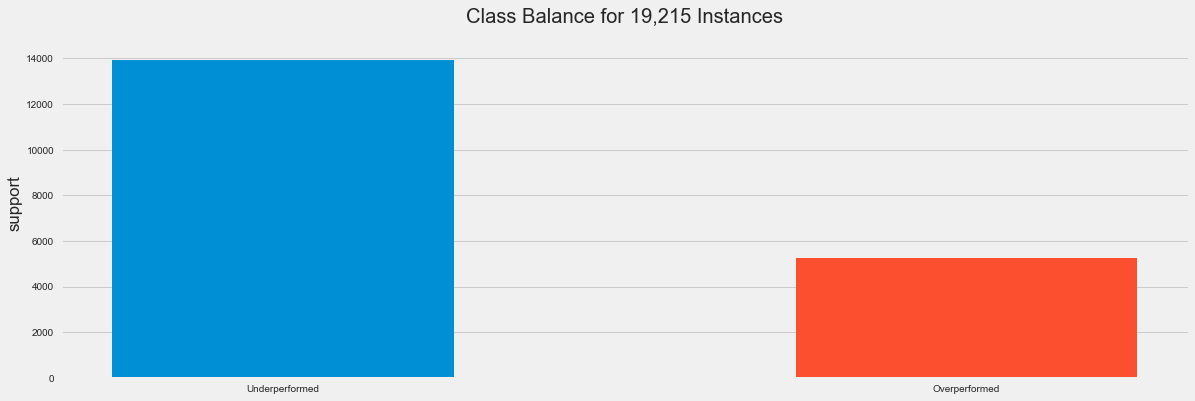

<AxesSubplot:title={'center':'Class Balance for 19,215 Instances'}, ylabel='support'>

In [290]:
y = df['performance']
visualizer = ClassBalance(labels=['Underperformed','Overperformed'])
plt.rcParams['figure.figsize'] = (18,6)
plt.style.use('fivethirtyeight')

visualizer.fit(y) # Fit the data to the visualizer
plt.savefig(
    '../../../fixtures/images/presentation_screenshots/Global_ClassImbalanceVisualizer.png',
    bbox_inches = "tight"
)
visualizer.show() # Finalize and render the figure

[reurn to top](#header_cell)
### Understanding the data through summary statistics
<a id='data_review_summary_cell'></a>

In [60]:
# Find out basic characteristics of the columns and, if necessary, drop columns with null values
df.info(verbose = True, null_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19215 entries, 0 to 19214
Data columns (total 110 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   GameKey                             19215 non-null  int64  
 1   PlayerID                            19215 non-null  int64  
 2   Season                              19215 non-null  int64  
 3   Week                                19215 non-null  int64  
 4   Team                                19215 non-null  object 
 5   Opponent                            19215 non-null  object 
 6   HomeOrAway                          19215 non-null  object 
 7   Position                            19215 non-null  object 
 8   PositionCategory                    19215 non-null  object 
 9   InjuryStatus                        19215 non-null  int64  
 10  TeamID                              19215 non-null  int64  
 11  OpponentID                          1921

In [61]:
df.head()

,GameKey,PlayerID,Season,Week,Team,Opponent,HomeOrAway,Position,PositionCategory,InjuryStatus,TeamID,OpponentID,ScoreID,week_id,OpponentRZ,days_since_last_game,absolute_hours_displaced,weather_temperature,weather_wind_mph_number,weather_wind_direction,weather_cloud_cover,weather_precipitation,weather_humidity,weather_detail,elevation_displacement,age,Played,Started,PassingAttempts,PassingCompletions,PassingYards,PassingCompletionPercentage,PassingYardsPerAttempt,PassingYardsPerCompletion,PassingTouchdowns,PassingInterceptions,PassingRating,PassingLong,PassingSacks,PassingSackYards,RushingAttempts,RushingYards,RushingYardsPerAttempt,RushingTouchdowns,RushingLong,ReceivingTargets,Receptions,ReceivingYards,ReceivingYardsPerReception,ReceivingTouchdowns,ReceivingLong,Fumbles,FumblesLost,PuntReturns,PuntReturnYards,PuntReturnTouchdowns,KickReturns,KickReturnYards,KickReturnTouchdowns,SoloTackles,AssistedTackles,TacklesForLoss,Sacks,SackYards,QuarterbackHits,PassesDefended,FumblesForced,FumblesRecovered,FumbleReturnTouchdowns,Interceptions,InterceptionReturnTouchdowns,FieldGoalsAttempted,FieldGoalsMade,ExtraPointsMade,TwoPointConversionPasses,TwoPointConversionRuns,TwoPointConversionReceptions,ExtraPointsAttempted,FieldGoalsMade0to19,FieldGoalsMade20to29,FieldGoalsMade30to39,FieldGoalsMade40to49,FieldGoalsMade50Plus,PointsAllowedByDefenseSpecialTeams,BlockedKickReturnTouchdowns,PointsAllowed,SpecialTeamsTouchdowns,DefensiveTouchdowns,BlockedKicks,TwoPointConversionReturns,FieldGoalReturnTouchdowns,Safeties,TouchdownsScored,PassingYardsRZ,PassingTouchdownsRZ,PassingInterceptionsRZ,RushingYardsRZ,RushingTouchdownsRZ,ReceptionsRZ,ReceivingYardsRZ,ReceivingTouchdownsRZ,SacksRZ,InterceptionsRZ,FumblesForcedRZ,FumlbesRecoveredRZ,performance,projected,actual,difference,performance_class
0,201910101,1,2019,1,ARZ,DET,HOME,DEF,DEF,0,1,11,16994,2019_1,0,365,0,72,0,No wind,0.39,0.0,0.32,DOME,0,25.354502,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.9,7.0,1.1,far overperformed
1,201910203,1,2019,2,ARZ,BLT,AWAY,DEF,DEF,0,1,3,17008,2019_2,0,7,2,81,3,North - NorthWest,0.00,0.0,0.45,Clear,3226593,25.354502,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,3.0,24.0,11.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0,0.0,27.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.4,2.0,-3.4,far underperformed
2,201910301,1,2019,3,ARZ,CAR,HOME,DEF,DEF,0,1,5,17024,2019_3,0,7,0,72,0,No wind,0.40,0.0,0.90,DOME,0,25.354502,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.5,2.0,14.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,0.0,23.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,-8.0,far underperformed
3,201910401,1,2019,4,ARZ,SEA,HOME,DEF,DEF,0,1,30,17041,2019_4,0,7,0,72,0,No wind,0.38,0.0,0.36,DOME,0,25.354502,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,21.0,4.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.0,0.0,38.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.7,4.0,-1.7,far underperformed
4,201910507,1,2019,5,ARZ,CIN,AWAY,DEF,DEF,0,1,7,17047,2019_5,0,7,2,76,6,West - SouthWest,0.87,0.0,0.60,Mostly Cloudy,1792624,25.354502,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,4.0,15.0,7.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [62]:
df.tail()

,GameKey,PlayerID,Season,Week,Team,Opponent,HomeOrAway,Position,PositionCategory,InjuryStatus,TeamID,OpponentID,ScoreID,week_id,OpponentRZ,days_since_last_game,absolute_hours_displaced,weather_temperature,weather_wind_mph_number,weather_wind_direction,weather_cloud_cover,weather_precipitation,weather_humidity,weather_detail,elevation_displacement,age,Played,Started,PassingAttempts,PassingCompletions,PassingYards,PassingCompletionPercentage,PassingYardsPerAttempt,PassingYardsPerCompletion,PassingTouchdowns,PassingInterceptions,PassingRating,PassingLong,PassingSacks,PassingSackYards,RushingAttempts,RushingYards,RushingYardsPerAttempt,RushingTouchdowns,RushingLong,ReceivingTargets,Receptions,ReceivingYards,ReceivingYardsPerReception,ReceivingTouchdowns,ReceivingLong,Fumbles,FumblesLost,PuntReturns,PuntReturnYards,PuntReturnTouchdowns,KickReturns,KickReturnYards,KickReturnTouchdowns,SoloTackles,AssistedTackles,TacklesForLoss,Sacks,SackYards,QuarterbackHits,PassesDefended,FumblesForced,FumblesRecovered,FumbleReturnTouchdowns,Interceptions,InterceptionReturnTouchdowns,FieldGoalsAttempted,FieldGoalsMade,ExtraPointsMade,TwoPointConversionPasses,TwoPointConversionRuns,TwoPointConversionReceptions,ExtraPointsAttempted,FieldGoalsMade0to19,FieldGoalsMade20to29,FieldGoalsMade30to39,FieldGoalsMade40to49,FieldGoalsMade50Plus,PointsAllowedByDefenseSpecialTeams,BlockedKickReturnTouchdowns,PointsAllowed,SpecialTeamsTouchdowns,DefensiveTouchdowns,BlockedKicks,TwoPointConversionReturns,FieldGoalReturnTouchdowns,Safeties,TouchdownsScored,PassingYardsRZ,PassingTouchdownsRZ,PassingInterceptionsRZ,RushingYardsRZ,RushingTouchdownsRZ,ReceptionsRZ,ReceivingYardsRZ,ReceivingTouchdownsRZ,SacksRZ,InterceptionsRZ,FumblesForcedRZ,FumlbesRecoveredRZ,performance,projected,actual,difference,performance_class
19210,202010924,22482,2020,9,NYJ,NE,HOME,K,ST,0,24,21,17396,2020_9,0,8,0,60,3,South - SouthWest,0.10,0.0,0.80,Clear,0,30.026198,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.14,11.0,4.86,far underperformed
19211,202011129,22482,2020,11,NYJ,LAC,AWAY,K,ST,0,24,29,17645,2020_11,0,13,3,69,4,SouthWest,0.28,0.0,0.55,Clear,180694,30.061316,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.18,0.0,-0.18,far underperformed
19212,202011224,22482,2020,12,NYJ,MIA,HOME,K,ST,0,24,19,17433,2020_12,0,7,0,51,3,SouthWest,0.00,0.0,0.44,Clear,0,30.080129,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.04,3.0,-3.04,far underperformed
19213,202011324,22482,2020,13,NYJ,LV,HOME,K,ST,0,24,25,17446,2020_13,0,7,0,39,13,NorthWest,0.21,0.0,0.54,Clear,0,30.099295,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.24,2.0,-4.24,underperformed
19214,202011430,22482,2020,14,NYJ,SEA,AWAY,K,ST,0,24,30,17465,2020_14,0,7,3,41,6,South - SouthEast,0.10,0.0,0.90,Overcast,69721,30.118812,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [63]:
df.describe()

,GameKey,PlayerID,Season,Week,InjuryStatus,TeamID,OpponentID,ScoreID,days_since_last_game,absolute_hours_displaced,weather_temperature,weather_wind_mph_number,weather_cloud_cover,weather_precipitation,weather_humidity,elevation_displacement,age,Played,Started,PassingAttempts,PassingCompletions,PassingYards,PassingCompletionPercentage,PassingYardsPerAttempt,PassingYardsPerCompletion,PassingTouchdowns,PassingInterceptions,PassingRating,PassingLong,PassingSacks,PassingSackYards,RushingAttempts,RushingYards,RushingYardsPerAttempt,RushingTouchdowns,RushingLong,ReceivingTargets,Receptions,ReceivingYards,ReceivingYardsPerReception,ReceivingTouchdowns,ReceivingLong,Fumbles,FumblesLost,PuntReturns,PuntReturnYards,PuntReturnTouchdowns,KickReturns,KickReturnYards,KickReturnTouchdowns,SoloTackles,AssistedTackles,TacklesForLoss,Sacks,SackYards,QuarterbackHits,PassesDefended,FumblesForced,FumblesRecovered,FumbleReturnTouchdowns,Interceptions,InterceptionReturnTouchdowns,FieldGoalsAttempted,FieldGoalsMade,ExtraPointsMade,TwoPointConversionPasses,TwoPointConversionRuns,TwoPointConversionReceptions,ExtraPointsAttempted,FieldGoalsMade0to19,FieldGoalsMade20to29,FieldGoalsMade30to39,FieldGoalsMade40to49,FieldGoalsMade50Plus,PointsAllowedByDefenseSpecialTeams,BlockedKickReturnTouchdowns,PointsAllowed,SpecialTeamsTouchdowns,DefensiveTouchdowns,BlockedKicks,TwoPointConversionReturns,FieldGoalReturnTouchdowns,Safeties,TouchdownsScored,PassingYardsRZ,PassingTouchdownsRZ,PassingInterceptionsRZ,RushingYardsRZ,RushingTouchdownsRZ,ReceptionsRZ,ReceivingYardsRZ,ReceivingTouchdownsRZ,SacksRZ,InterceptionsRZ,FumblesForcedRZ,FumlbesRecoveredRZ,performance,projected,actual,difference
count,1.921500e+04,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,1.921500e+04,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.00000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.00000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.0,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.0,19215.0,19215.000000,19215.0,19215.000000,19215.000000,19215.000000,19215.000000
mean,2.019616e+08,16929.806037,2019.507104,9.100286,0.038251,17.972678,17.756596,17258.040853,26.297788,0.506427,62.605829,4.889722,0.393791,0.018771,0.621109,1.050382e+06,26.508028,0.718501,0.329482,1.736872,1.122248,12.597138,3.759308,0.43744,0.654749,0.081395,0.038251,5.361079,2.044965,0.116732,0.783607,1.309394,5.700494,0.852615,0.047047,2.190060,1.657715,1.114390,12.527921,3.928186,0.079625,6.20791,0.054749,0.026282,0.072339,0.600052,0.001353,0.079365,1.771429,0.001093,0.063908,0.014572,0.268800,0.118345,0.793130,0.290242,0.000104,0.042831,0.029560,0.002810,0.039032,0.003175,0.093156,0.077804,0.114598,0.003955,0.001821,0.003903,0.122560,0.000677,0.020973,0.023679,0.023159,0.009316,1.146552,0.000468,1.185480,0.001874,0.005829,0.002810,0.000052,0.0,0.001926,0.007702,0.894249,0.056466,0.004215,0.651835,0.041634,0.129742,0.888108,0.055009,0.0,0.0,0.000104,0.0,0.274161,4.261863,4.280412,0.018550
std,5.000395e+04,5575.428964,0.499963,5.018690,0.191807,10.432115,10.463184,165.690724,74.542025,0.906557,15.328872,4.437656,0.3

[reurn to top](#header_cell)
### Preparing the data
<a id='preparing_data_cell'></a>

Drop the season column, split into X and y for machin learning

In [64]:
df = df.drop('Season', axis = 'columns').sort_values(by = ['Week']).reset_index(drop = True)
df

,GameKey,PlayerID,Week,Team,Opponent,HomeOrAway,Position,PositionCategory,InjuryStatus,TeamID,OpponentID,ScoreID,week_id,OpponentRZ,days_since_last_game,absolute_hours_displaced,weather_temperature,weather_wind_mph_number,weather_wind_direction,weather_cloud_cover,weather_precipitation,weather_humidity,weather_detail,elevation_displacement,age,Played,Started,PassingAttempts,PassingCompletions,PassingYards,PassingCompletionPercentage,PassingYardsPerAttempt,PassingYardsPerCompletion,PassingTouchdowns,PassingInterceptions,PassingRating,PassingLong,PassingSacks,PassingSackYards,RushingAttempts,RushingYards,RushingYardsPerAttempt,RushingTouchdowns,RushingLong,ReceivingTargets,Receptions,ReceivingYards,ReceivingYardsPerReception,ReceivingTouchdowns,ReceivingLong,Fumbles,FumblesLost,PuntReturns,PuntReturnYards,PuntReturnTouchdowns,KickReturns,KickReturnYards,KickReturnTouchdowns,SoloTackles,AssistedTackles,TacklesForLoss,Sacks,SackYards,QuarterbackHits,PassesDefended,FumblesForced,FumblesRecovered,FumbleReturnTouchdowns,Interceptions,InterceptionReturnTouchdowns,FieldGoalsAttempted,FieldGoalsMade,ExtraPointsMade,TwoPointConversionPasses,TwoPointConversionRuns,TwoPointConversionReceptions,ExtraPointsAttempted,FieldGoalsMade0to19,FieldGoalsMade20to29,FieldGoalsMade30to39,FieldGoalsMade40to49,FieldGoalsMade50Plus,PointsAllowedByDefenseSpecialTeams,BlockedKickReturnTouchdowns,PointsAllowed,SpecialTeamsTouchdowns,DefensiveTouchdowns,BlockedKicks,TwoPointConversionReturns,FieldGoalReturnTouchdowns,Safeties,TouchdownsScored,PassingYardsRZ,PassingTouchdownsRZ,PassingInterceptionsRZ,RushingYardsRZ,RushingTouchdownsRZ,ReceptionsRZ,ReceivingYardsRZ,ReceivingTouchdownsRZ,SacksRZ,InterceptionsRZ,FumblesForcedRZ,FumlbesRecoveredRZ,performance,projected,actual,difference,performance_class
0,201910101,1,1,ARZ,DET,HOME,DEF,DEF,0,1,11,16994,2019_1,0,365,0,72,0,No wind,0.39,0.0,0.32,DOME,0,25.354502,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.90,7.00,1.10,far overperformed
1,202010105,20924,1,LV,CAR,AWAY,WR,OFF,0,25,5,17270,2020_1,CAR,259,3,79,3,NorthEast,0.17,0.0,0.66,Clear,2208777,24.732997,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.45,2.10,-3.35,far underperformed
2,201910125,20924,1,LV,DEN,HOME,WR,OFF,0,25,10,16998,2019_1,DEN,365,0,64,10,West - SouthWest,0.20,0.0,0.69,Partly Cloudy,0,23.721036,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.34,1.30,-3.04,far underperformed
3,201910125,16311,1,LV,DEN,HOME,QB,OFF,0,25,10,16998,2019_1,DEN,365,0,64,10,West - SouthWest,0.20,0.0,0.69,Partly Cloudy,0,28.454877,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,13.04,14.56,1.52,far overperformed
4,202010111,20925,1,CHI,DET,AWAY,WR,OFF,0,6,11,17266,2020_1,0,259,1,72,0,No wind,0.12,0.0,0.65,DOME,64922,24.149823,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

Split the data into X and y, dropping any of the target dataset columns; score, game, team, and player IDs, and week_id

In [65]:
# Split dataframe into two dataframes: X will have all but target, y will have target
X = df.drop([
    'performance',
    'performance_class',
    'projected',
    'actual',
    'difference',
    'GameKey',
    'TeamID',
    'OpponentID',
    'ScoreID',
    'GameKey',
    'PlayerID',
    'TeamID',
    'OpponentID',
    'ScoreID',
    'week_id'
], axis = 'columns')

y = df['performance']

[reurn to top](#header_cell)
## Global Machine Learning Model
<a id='global_model_cell'></a>

Because of this class imbalance and my unwillingness to get rid of over half of the data, I will not be focusing on precision, and will instead focus on recall. This is also due to the utility of this model: I want to cast a wider net to find more potential overperformers and, in doing so, take in some underperformers, since I'm banking on my ability to sort out the false positives.

First I'll try a handful of models without tuning parameters to see which ones work best. I'll evaluate these models by seeking as high a recall score for overperformance as possible. The reason I'll do that is because I want to cast the widest net for possible over-performers since there are so many underperformers and I want to peel out the players with the highest potential. Then, I'll perform feature importance to find out if any features are not assisting with the model. Next, I'll select a model and tune its parameters to improve the recall of overperformance. Finally, I'll do TimeSeriesSplit Cross Validation of my data to ensure my model is time-aware.

[reurn to top](#header_cell)
### Model Selection
<a id='model_selection_cell'></a>

#### Selecting Columns 
<a id='column_selection_cell'></a>

In preparation for our pipeline, I'll instantiate column selectors for each column to standardize data preparation without hard-coding it

From the [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_selector.html):
> Create a callable to select columns to be used with ColumnTransformer.   
>   
>```make_column_selector``` can select columns based on datatype or the columns name with a regex. When using multiple selection criteria, all criteria must match for a column to be selected.

In [66]:
categorical = make_column_selector(dtype_include=np.object)
numeric = make_column_selector(dtype_include=np.int64)
numeric2 = make_column_selector(dtype_include=np.float64)

#### Selecting models to score
<a id='model_scoring_selection_cell'></a>

I'll start with an initial slate of models with default parameters for the following reasons:

| Model | Reason for Selection |
| :----------- | :----------- |
|```SVC()```| [Effective in high dimensional spaces](https://scikit-learn.org/stable/modules/svm.html#svm-classification) as a binary classifier, and effectively handles unbalanced classes |
|```NuSVC()```| Similar to SVC, but includes a parameter to [control the number of support vectors](https://scikit-learn.org/stable/modules/generated/sklearn.svm.NuSVC.html#sklearn.svm.NuSVC) |
|```LinearSVC()```| Similar to SVC and scales better to large numbers of samples. Also has more flexibility in the choice of [penalties](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC) |
|```SGDClassifier()```| [Efficient](https://towardsdatascience.com/using-stochastic-gradient-descent-to-train-linear-classifiers-c80f6aeaff76) model for evaluating many thousands of training data points |
|```KNeighborsClassifier()```| Unlike linear models (which try to draw distinctive lines between classes), [classifies based on nearest neighbors](https://towardsdatascience.com/k-nearest-neighbors-94395f445221) in dataset |
|```LogisticRegression()```| A binary classifier that handles imbalanced classes [well](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression) |
|```LogisticRegressionCV()```| Similar to LogisticRegression, but uses [cross validation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html) as well |
|```BaggingClassifier()```| Uses base estimators, then [aggregates them](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html), which may help find signal in the noise better than the others |
|```ExtraTreesClassifier()```| [Controls over-fitting](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html) by fitting randomized decision trees on the data (which may help with the class imbalance) |
|```RandomForestClassifier()```| Unlike ExtraTreesClassifier, this chooses the [optimal](https://quantdare.com/what-is-the-difference-between-extra-trees-and-random-forest/#:~:text=Random%20Forest%20chooses%20the%20optimum,randomization%20but%20still%20has%20optimization.) decision tree split |

In [67]:
# list of models to use
models = [
    SVC(),
    NuSVC(),
    LinearSVC(),
    SGDClassifier(),
    KNeighborsClassifier(),
    LogisticRegression(),
    LogisticRegressionCV(),
    BaggingClassifier(),
    ExtraTreesClassifier(),
    RandomForestClassifier()
]

Here's a function to send each model through a pipeline and spit out an F1 score at the end

In [68]:
# function to score models
def score_model(X, y, estimator, **kwargs):
    """
    Test various estimators.
    """
    y = LabelEncoder().fit_transform(y)
    
    # handle_unknown='ignore' in OneHotEncoder() is used because weather_detail data gave it trouble
    model = Pipeline([
    ("columns", ColumnTransformer([
        ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical),
        ('scalar', MinMaxScaler(), numeric),
        ('scalar2', MinMaxScaler(), numeric2),
    ], remainder='drop')),
        ("imputer",SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('estimator', estimator)
    ])

    #add train/test split (train 14 weeks and below, test above 14 weeks)
    y_train = y[:X.index[X['Week'] > 14].tolist()[0]]
    y_test = y[X.index[X['Week'] > 14].tolist()[0]:]
    X_train = X[:X.index[X['Week'] > 14].tolist()[0]].drop('Week', axis = 'columns')
    X_test = X[X.index[X['Week'] > 14].tolist()[0]:].drop('Week', axis = 'columns')
    
    # Instantiate the classification model and visualizer
    model.fit(X_train, y_train, **kwargs) #updated to train with train set
    expected  = y_test #updated with test set
    predicted = model.predict(X_test)  #updated with test set
    
    # Compute and return F1 (harmonic mean of precision and recall)
    print("F1 SCORE {}: {}".format(estimator.__class__.__name__, f1_score(expected, predicted)))

Here's a function to send each model through the same pipeline and spit out a visualization of precision, recall, and F1 scores for each class at the end

In [69]:
# function to visualize models
def visualize_model(X, y, estimator, **kwargs):
    """
    Visualizes models
    """
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
    ("columns", ColumnTransformer([
        ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical),
        ('scalar', MinMaxScaler(), numeric),
        ('scalar2', MinMaxScaler(), numeric2),
    ], remainder='drop')),
    ('estimator', estimator)
    ])
    
    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(
        model, classes=['Underperformed', 'Overperformed'],
        cmap="YlGn", size=(600, 360), **kwargs
    )
    
    
    #add train/test split (train 14 weeks and below, test above 14 weeks)
    y_train = y[:X.index[X['Week'] > 14].tolist()[0]]
    y_test = y[X.index[X['Week'] > 14].tolist()[0]:]
    X_train = X[:X.index[X['Week'] > 14].tolist()[0]].drop('Week', axis = 'columns')
    X_test = X[X.index[X['Week'] > 14].tolist()[0]:].drop('Week', axis = 'columns')
    
    visualizer.fit(X_train, y_train) #updated with train set
    visualizer.score(X_test, y_test) #updated with test set
    visualizer.show()

[reurn to top](#header_cell)
#### Scoring and visualizing selected models
<a id='scoring_models_cell'></a>

Iterate through list of initial models using X and y as defined above

F1 SCORE SVC: 0.5392061955469507


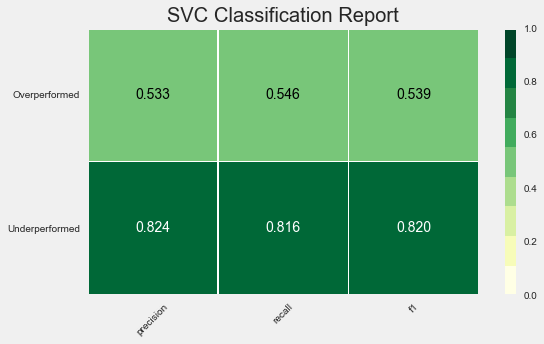

F1 SCORE NuSVC: 0.544840887174542


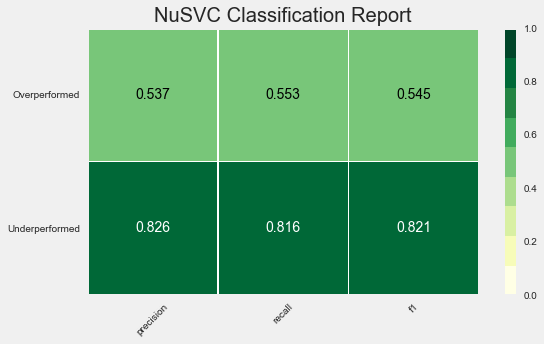

F1 SCORE LinearSVC: 0.5135273098519654


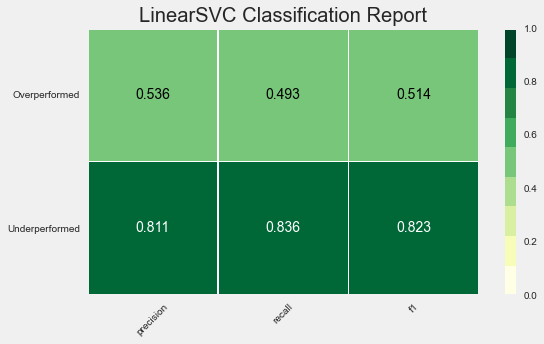

F1 SCORE SGDClassifier: 0.5279441117764471


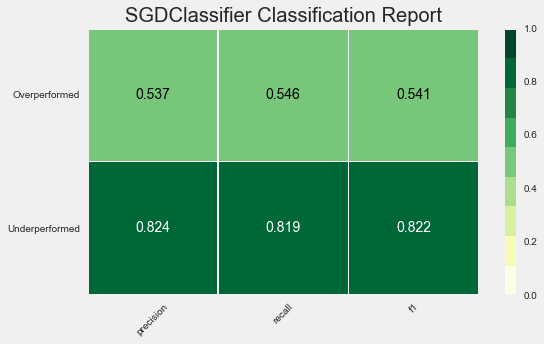

F1 SCORE KNeighborsClassifier: 0.40368027602070156


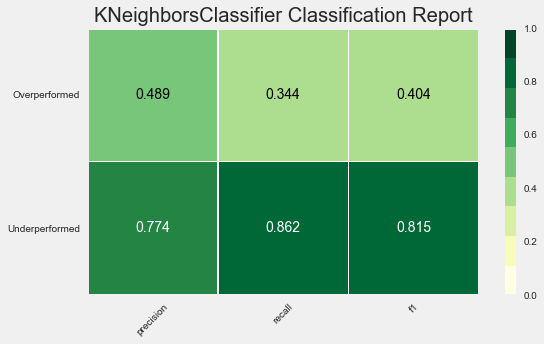

/Users/aidanoconnor/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


F1 SCORE LogisticRegression: 0.5125576627370578


/Users/aidanoconnor/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


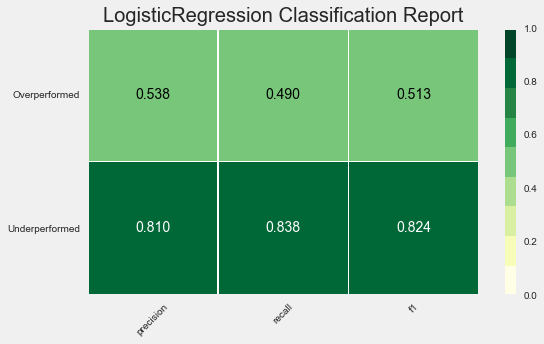

/Users/aidanoconnor/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/aidanoconnor/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

/Users/aidanoconnor/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/aidanoconnor/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

F1 SCORE LogisticRegressionCV: 0.5070422535211269


/Users/aidanoconnor/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/aidanoconnor/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

/Users/aidanoconnor/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/aidanoconnor/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

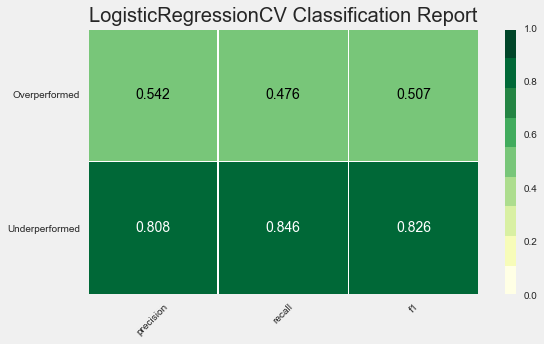

F1 SCORE BaggingClassifier: 0.4741288278775079


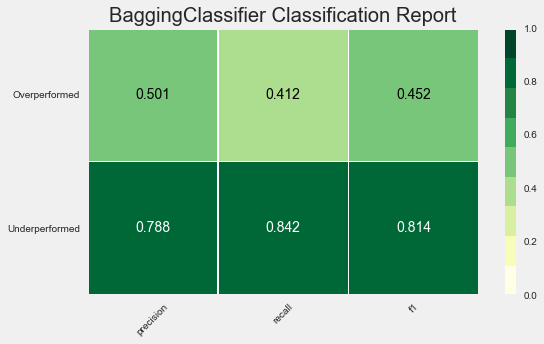

F1 SCORE ExtraTreesClassifier: 0.4844398340248963


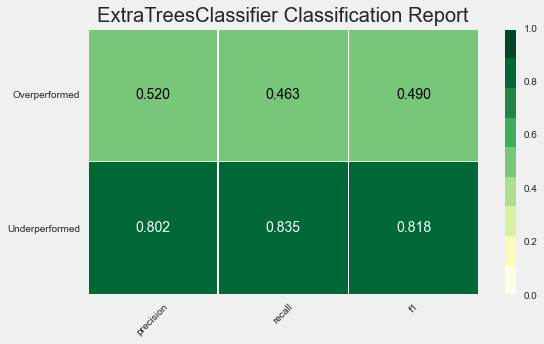

F1 SCORE RandomForestClassifier: 0.4859416445623342


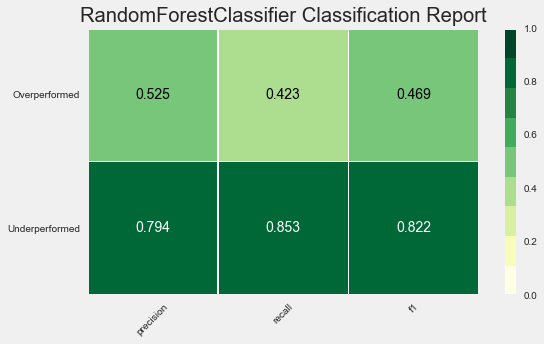

In [70]:
for model in models:
    score_model(X, y, model)
    visualize_model(X, y, model)

[reurn to top](#header_cell)
#### Adding basic parameters to initial slate of models
<a id='basic_parameter_tuning_cell'></a>

I'll add some basic parameter tuning for this slate of models before cutting any from the model selection process

In [71]:
# list of models to use
modified_models = [
    SVC(gamma = 'auto'),
    NuSVC(gamma = 'auto'),
    LinearSVC(max_iter = 2000),
    SGDClassifier(max_iter = 100, tol = 1e-3),
    KNeighborsClassifier(n_neighbors = 10),
    LogisticRegression(solver = 'lbfgs'),
    LogisticRegressionCV(cv=3, max_iter=100),
    BaggingClassifier(n_estimators = 15),
    ExtraTreesClassifier(n_estimators = 300),
    RandomForestClassifier(n_estimators = 300)
]

Trying the list of modified models with some basic paramater tuning

F1 SCORE SVC: 0.5522531160115052


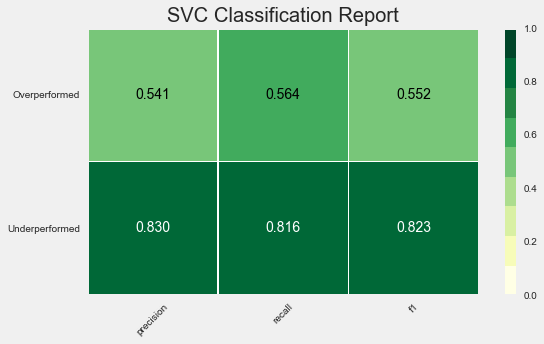

F1 SCORE NuSVC: 0.5522531160115052


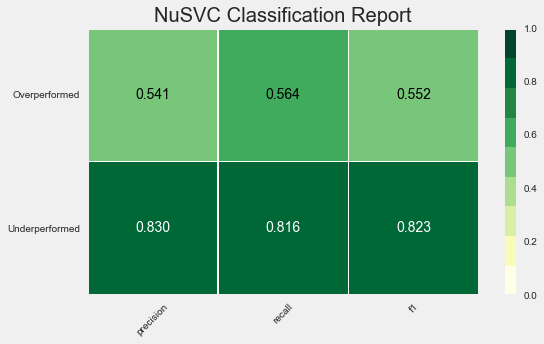

F1 SCORE LinearSVC: 0.5135273098519654


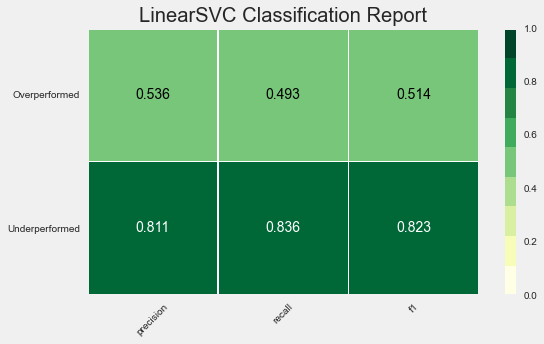

F1 SCORE SGDClassifier: 0.5431619786614936


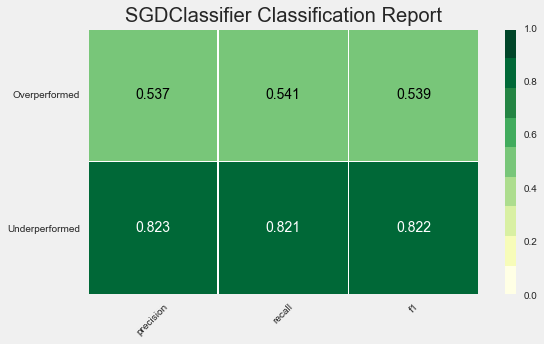

F1 SCORE KNeighborsClassifier: 0.3066392881587954


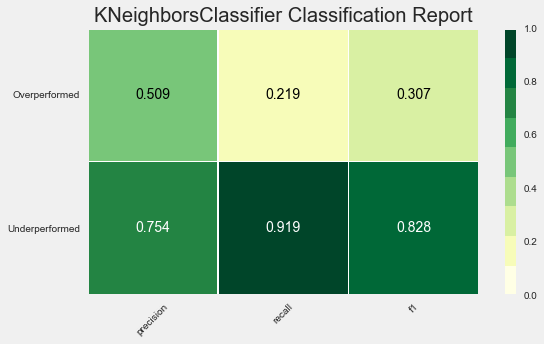

/Users/aidanoconnor/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


F1 SCORE LogisticRegression: 0.5125576627370578


/Users/aidanoconnor/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


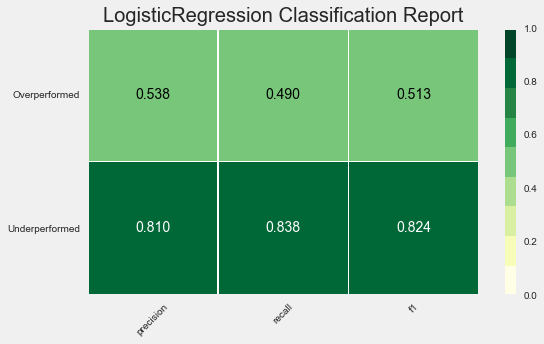

/Users/aidanoconnor/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/aidanoconnor/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

F1 SCORE LogisticRegressionCV: 0.5070422535211269


/Users/aidanoconnor/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/aidanoconnor/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

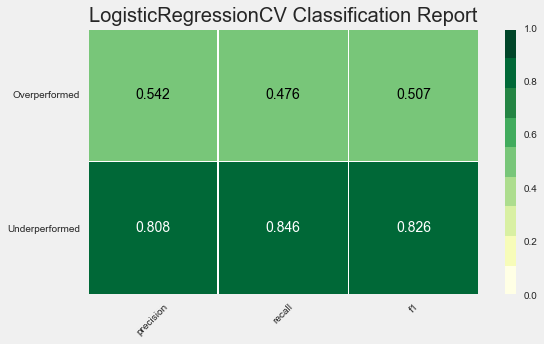

F1 SCORE BaggingClassifier: 0.4886251236399604


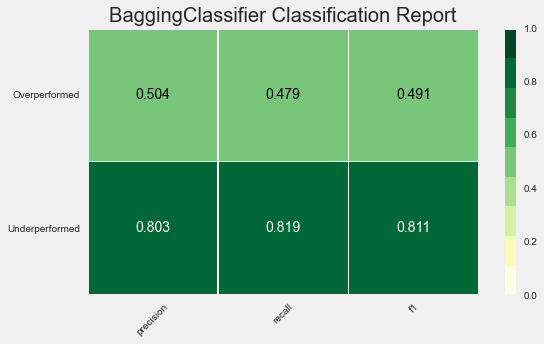

F1 SCORE ExtraTreesClassifier: 0.49590163934426235


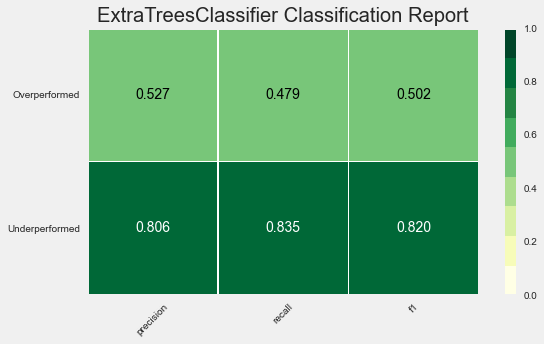

F1 SCORE RandomForestClassifier: 0.4927083333333333


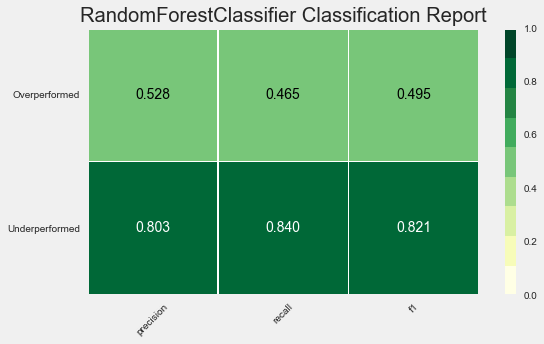

In [72]:
# iterate through list of models through both functions defined above
# Use X and y dataframes first, which contain all of the data
for model in modified_models:
    score_model(X, y, model)
    visualize_model(X, y, model)

[reurn to top](#header_cell)
#### Setting aside the good models
<a id='good_models_cell'></a>

The warnings tell me that some of the models need some slight tuning to improve. I'll give these some more tries and separate my models into two lists: one to run GridSearch on (those currently with better than 0.5 recall for overperformance) and one to try to improve lower-performing models (those currently with lower than 0.5 recall for overperformance) before moving on.

In [73]:
good_models = [
    # SVC: 0.564
    SVC(gamma='auto'),
    # NuSVC: 0.564
    NuSVC(gamma='auto'),
    # SGDClassifier: 0.542
    SGDClassifier(max_iter=100, tol=1e-3),
]

[reurn to top](#header_cell)
#### Adjusting basic parameters of a few problem models
<a id='basic_parameter_tuning_problem_models_cell'></a>

LinearSVC's max_iter default is 1000, I used 2000 last time, so I'll try to over-correct this time to find the middle ground.   

LogisticRegression's and LogisticRegressionCV's max_iter default is 100, so I'll do something similar as what I'm doing with LinearSVC.   

KNeighborsClassifier's number of nearest neighbors default is 5, so I'll make it 10.   

BaggingClassifier's number of estimators default is 10, so I'll make it 20.   

I tried 300 estimators for ExtraTreesClassifier and RandomForestClassifier, so I'll try 600 now.

In [74]:
other_models = [
    # LinearSVC: 0493
    LinearSVC(max_iter = 6000),
    # KNeighborsClassifier: 0.344
    KNeighborsClassifier(n_neighbors = 10),
    # LogisticRegression: 0.490
    LogisticRegression(solver='lbfgs', max_iter = 2000),
    # LogisticRegressionCV: 0.476
    LogisticRegressionCV(cv=3, max_iter=600),
    # BaggingClassifier: 0.409
    BaggingClassifier(n_estimators = 20),
    # ExtraTreesClassifier: 0.471
    ExtraTreesClassifier(n_estimators = 600),
    # RandomForestClassifier: 0.465
    RandomForestClassifier(n_estimators = 600)
]

F1 SCORE LinearSVC: 0.5135273098519654


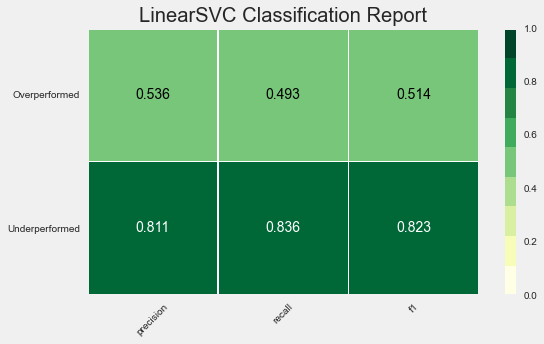

F1 SCORE KNeighborsClassifier: 0.3066392881587954


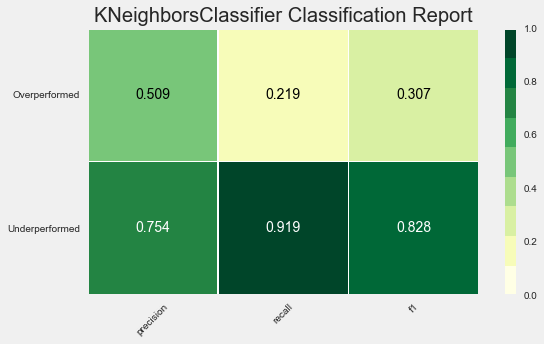

F1 SCORE LogisticRegression: 0.5097636176772867


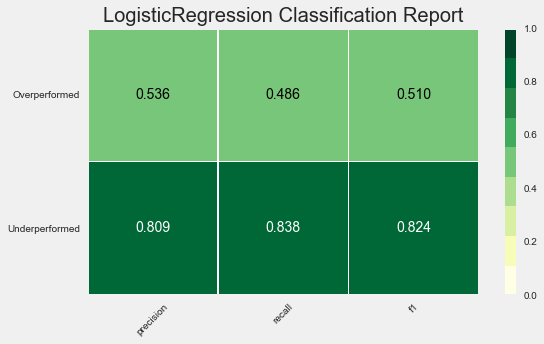

F1 SCORE LogisticRegressionCV: 0.5089789635710621


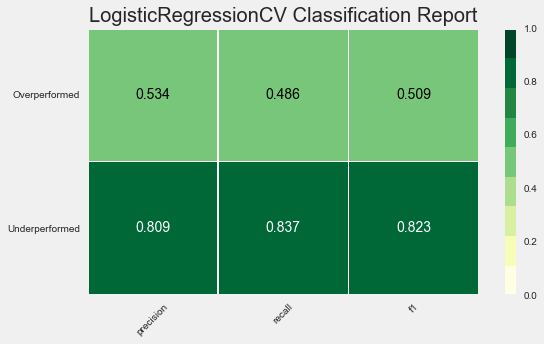

F1 SCORE BaggingClassifier: 0.4711538461538462


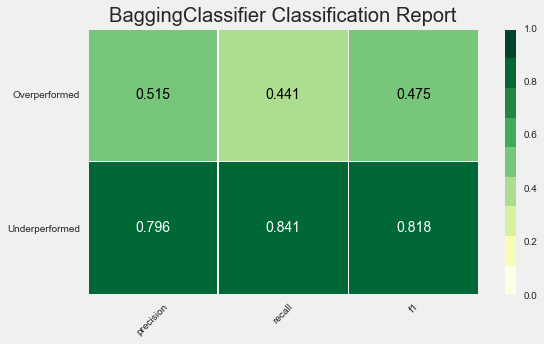

F1 SCORE ExtraTreesClassifier: 0.49589322381930184


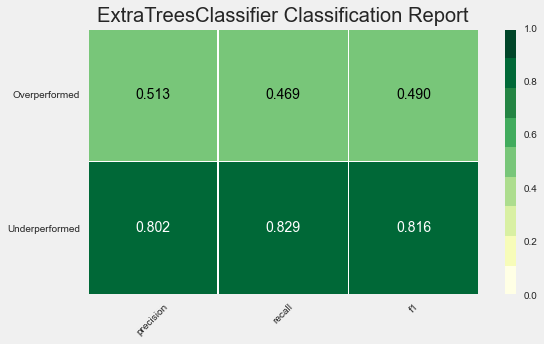

F1 SCORE RandomForestClassifier: 0.4968814968814969


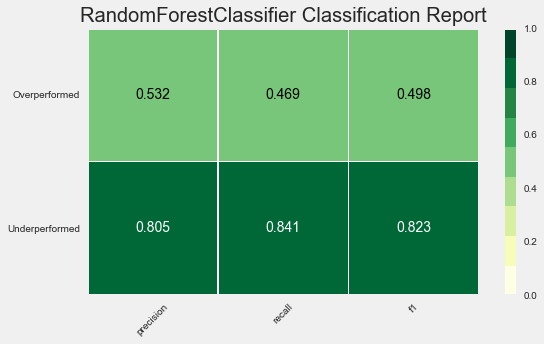

In [75]:
# iterate through list of models through both functions defined above
# Use X and y dataframes first, which contain all of the data
for model in other_models:
    score_model(X, y, model)
    visualize_model(X, y, model)

The models that showed improvement in recalling overperformers:   
* LogisticRegressionCV: +.01
* **BaggingClassifier: +.021**
* RandomForestClassifier: +.005

I'll add the BaggingClassifier to the down-select of good_models as a wild card

[reurn to top](#header_cell)
#### Further tuning parameters of good models
<a id='further_tuning_good_models_cell'></a>

In [76]:
good_models.append(BaggingClassifier(n_estimators = 20))
good_models

[SVC(gamma='auto'),
 NuSVC(gamma='auto'),
 SGDClassifier(max_iter=100),
 BaggingClassifier(n_estimators=20)]

Next steps: account for class imbalance by penalizing models for making mistakes when predicting the minority class. Credit to this [article](https://elitedatascience.com/imbalanced-classes) for this quote explaining penalty:

>During training, we can use the argument ```class_weight='balanced'```  to penalize mistakes on the minority class by an amount proportional to how under-represented it is.

I'll make class weights balanced and double the amount of estimators for the BaggingClassifier

In [77]:
good_models = [
    ## SVC: 0.564
    SVC(
        gamma = 'auto',
        class_weight = 'balanced'
    ),
    # NuSVC: 0.564
    NuSVC(
        gamma = 'auto',
        class_weight = 'balanced'
    ),
    # SGDClassifier: 0.542
    SGDClassifier(
        max_iter = 100,
        class_weight = 'balanced'
    ),
    # BaggingClassifier: 0.434
    BaggingClassifier(
        n_estimators = 40
    )
]

Run the score and visualization functions on the good models

F1 SCORE SVC: 0.589271417133707


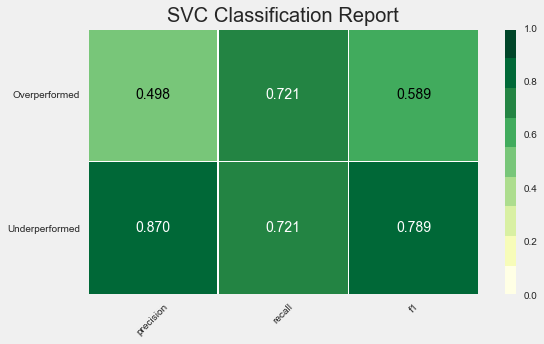

F1 SCORE NuSVC: 0.5522531160115052


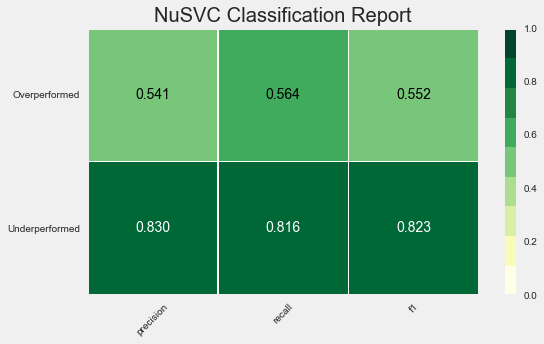

F1 SCORE SGDClassifier: 0.589271417133707


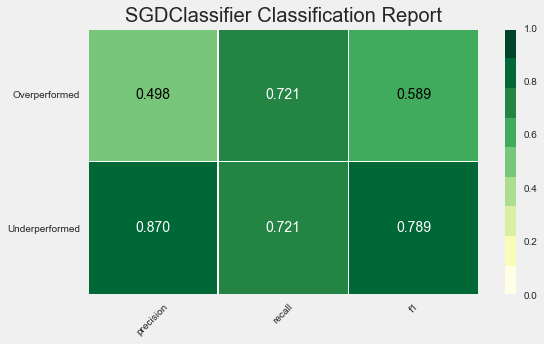

F1 SCORE BaggingClassifier: 0.4892528147389969


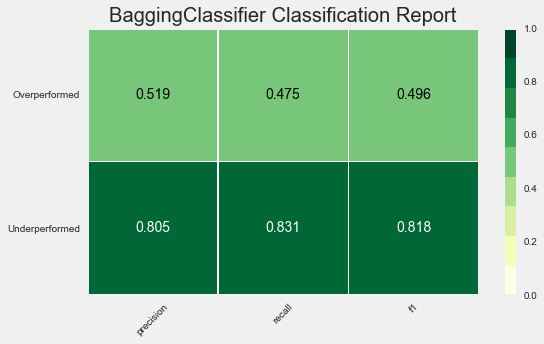

In [78]:
# iterate through list of models through both functions defined above
# Use X and y dataframes first, which contain all of the data
for model in good_models:
    score_model(X, y, model)
    visualize_model(X, y, model)

Great improvement on SVC and SGDClassifier!   

Some improvement on BaggingClassifier, but the separation between the best two and worst two is too great to continue with the latter.  

[reurn to top](#header_cell)
### Grid Search
<a id='grid_search_cell'></a>

#### Grid Searching the Support Vector Classifier
<a id='svc_gridsearch_cell'></a>

I'll start by setting different parameters for grid search to go through for, including:
* C: 4 variations of the regularization parameter
* kernel: linear model and radial basis function
* gamma: 5 kernel coefficient variations
* class_weight balanced for our imbalanced class

In [79]:
param_grid_SVC = {
    'C' : [1, 10],
    'gamma' : ['scale','auto'],
    'kernel' : ['linear', 'rbf'],
    'class_weight' : ['balanced']
}

Make a pre-processing pipeline to send the SVC model through prior to GridSearchCV

In [80]:
preprocessor = Pipeline(
    [
        ("columns", ColumnTransformer(
            [
                ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical),
                ('scalar', MinMaxScaler(), numeric),
                ('scalar2', MinMaxScaler(), numeric2),
            ], remainder='drop')),
        ("imputer",SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

Apply the preprocessor to ```X_train``` and ```X_test```

In [81]:
y_train = y[:X.index[X['Week'] > 14].tolist()[0]]
y_test = y[X.index[X['Week'] > 14].tolist()[0]:]
X_train = X[:X.index[X['Week'] > 14].tolist()[0]].drop('Week', axis = 'columns')
X_test = X[X.index[X['Week'] > 14].tolist()[0]:].drop('Week', axis = 'columns')

In [82]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.fit_transform(X_test)

Apply a LabelEncoder to ```y_train``` and ```y_test```

In [83]:
y_train = LabelEncoder().fit_transform(y_train)
y_test = LabelEncoder().fit_transform(y_test)

Set up and run GridSearchCV

In [84]:
grid = GridSearchCV(
    # model: SVC
    SVC(),
    # Using the parameters defined above
    param_grid_SVC,
    # Refit an estimator using the best found parameters on the whole dataset
    refit = True,
    # >1 : the computation time for each fold and parameter candidate is displayed;
    # >2 : the score is also displayed;
    verbose = 2,
    # Maximize CPU
    n_jobs = -1
)

In [85]:
grid.fit(X_train,y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 56.1min
[Parallel(n_jobs=-1)]: Done  38 out of  40 | elapsed: 64.2min remaining:  3.4min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 64.7min finished


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [1, 10], 'class_weight': ['balanced'],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf']},
             verbose=2)

Find the best parameters for the SVC model

In [86]:
grid.best_params_

{'C': 1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}

See how these parameters make the model perform

F1 SCORE SVC: 0.589271417133707


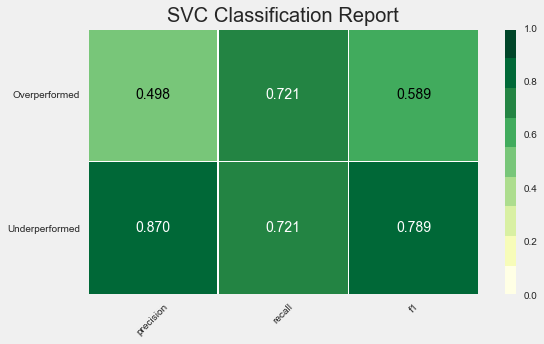

In [87]:
score_model(X, y, SVC(
    C = 1,
    class_weight = 'balanced',
    gamma = 'scale',
    kernel = 'rbf'
))    

visualize_model(X, y, SVC(
    C = 1,
    class_weight = 'balanced',
    gamma = 'scale',
    kernel = 'rbf'
))

[reurn to top](#header_cell)
### SDG Classifier GridSearchCV

#### Grid Searching the Stochastic Gradient Descent Classifier
<a id='sdg_gridsearch_cell'></a>

I'll start by setting different parameters for grid search to go through for, including:
* loss: measures model (mis) fit. 'hinge' is similar to SVC, and 'log' is similar to logsitic regressiono
* max_iter: 100 and 500 passes over the training data
* penalty: L1 (leads to sparse solutions) and L2
* n_jobs: -1 maximizes CPUs used to speed up the model
* class_weight: balanced for our imbalanced class

In [88]:
param_grid_SDGClassifier = {
    'loss': ['hinge','log'],
    'max_iter' : [100, 500],
    'penalty': ['l1','l2'],
    'n_jobs': [-1],
    'class_weight' : ['balanced']
}

In [89]:
grid = GridSearchCV(
    # model: SVC
    SGDClassifier(),
    # Using the parameters defined above
    param_grid_SDGClassifier,
    # Refit an estimator using the best found parameters on the whole dataset
    refit = True,
    # >1 : the computation time for each fold and parameter candidate is displayed;
    # >2 : the score is also displayed;
    verbose = 2
)

In [90]:
grid.fit(X_train,y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] class_weight=balanced, loss=hinge, max_iter=100, n_jobs=-1, penalty=l1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  class_weight=balanced, loss=hinge, max_iter=100, n_jobs=-1, penalty=l1, total=   1.1s
[CV] class_weight=balanced, loss=hinge, max_iter=100, n_jobs=-1, penalty=l1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV]  class_weight=balanced, loss=hinge, max_iter=100, n_jobs=-1, penalty=l1, total=   0.7s
[CV] class_weight=balanced, loss=hinge, max_iter=100, n_jobs=-1, penalty=l1 
[CV]  class_weight=balanced, loss=hinge, max_iter=100, n_jobs=-1, penalty=l1, total=   0.8s
[CV] class_weight=balanced, loss=hinge, max_iter=100, n_jobs=-1, penalty=l1 
[CV]  class_weight=balanced, loss=hinge, max_iter=100, n_jobs=-1, penalty=l1, total=   1.1s
[CV] class_weight=balanced, loss=hinge, max_iter=100, n_jobs=-1, penalty=l1 
[CV]  class_weight=balanced, loss=hinge, max_iter=100, n_jobs=-1, penalty=l1, total=   1.1s
[CV] class_weight=balanced, loss=hinge, max_iter=100, n_jobs=-1, penalty=l2 
[CV]  class_weight=balanced, loss=hinge, max_iter=100, n_jobs=-1, penalty=l2, total=   0.6s
[CV] class_weight=balanced, loss=hinge, max_iter=100, n_jobs=-1, penalty=l2 
[CV]  class_weight=balanced, loss=hinge, max_iter=100, n_jobs=-1, penalty=l2, total=   0.7s
[CV] class_weight=balanced, loss=hinge, max_iter=100, n_jobs=-1

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   24.1s finished


GridSearchCV(estimator=SGDClassifier(),
             param_grid={'class_weight': ['balanced'], 'loss': ['hinge', 'log'],
                         'max_iter': [100, 500], 'n_jobs': [-1],
                         'penalty': ['l1', 'l2']},
             verbose=2)

In [91]:
grid.best_params_

{'class_weight': 'balanced',
 'loss': 'hinge',
 'max_iter': 100,
 'n_jobs': -1,
 'penalty': 'l1'}

See how these parameters make the model perform

F1 SCORE SGDClassifier: 0.589271417133707


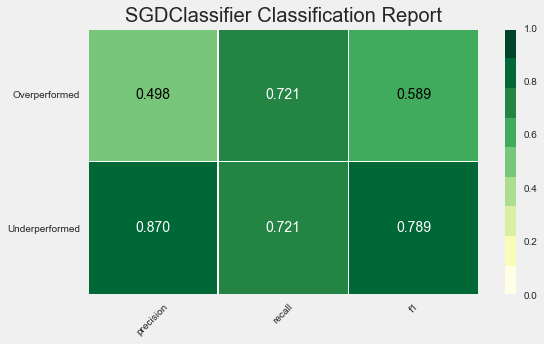

In [92]:
score_model(X, y, SGDClassifier(
    class_weight = 'balanced',
    loss = 'hinge',
    max_iter = 500,
    n_jobs = -1,
    penalty = 'l1'
)) 

visualize_model(X, y, SGDClassifier(
    class_weight = 'balanced',
    loss = 'hinge',
    max_iter = 500,
    n_jobs = -1,
    penalty = 'l1'
))

[reurn to top](#header_cell)
#### Visualizing Model Performance with a Confusion Matrix
<a id='confusion_matrix_cell'></a>

In [319]:
# Split dataframe into two dataframes: X will have all but target, y will have target
X = df.drop([
    'performance',
    'performance_class',
    'projected',
    'actual',
    'difference',
    'GameKey',
    'TeamID',
    'OpponentID',
    'ScoreID',
    'GameKey',
    'PlayerID',
    'TeamID',
    'OpponentID',
    'ScoreID',
    'week_id'
], axis = 'columns')

y = df['performance']

In [307]:
y_train = y[:X.index[X['Week'] > 14].tolist()[0]]
y_test = y[X.index[X['Week'] > 14].tolist()[0]:]
X_train = X[:X.index[X['Week'] > 14].tolist()[0]].drop('Week', axis = 'columns')
X_test = X[X.index[X['Week'] > 14].tolist()[0]:].drop('Week', axis = 'columns')

preprocessor = Pipeline(
    [
        ("columns", ColumnTransformer(
            [
                ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical),
                ('scalar', MinMaxScaler(), numeric),
                ('scalar2', MinMaxScaler(), numeric2),
            ], remainder='drop')),
        ("imputer",SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

y_train = LabelEncoder().fit_transform(y_train)
y_test = LabelEncoder().fit_transform(y_test)

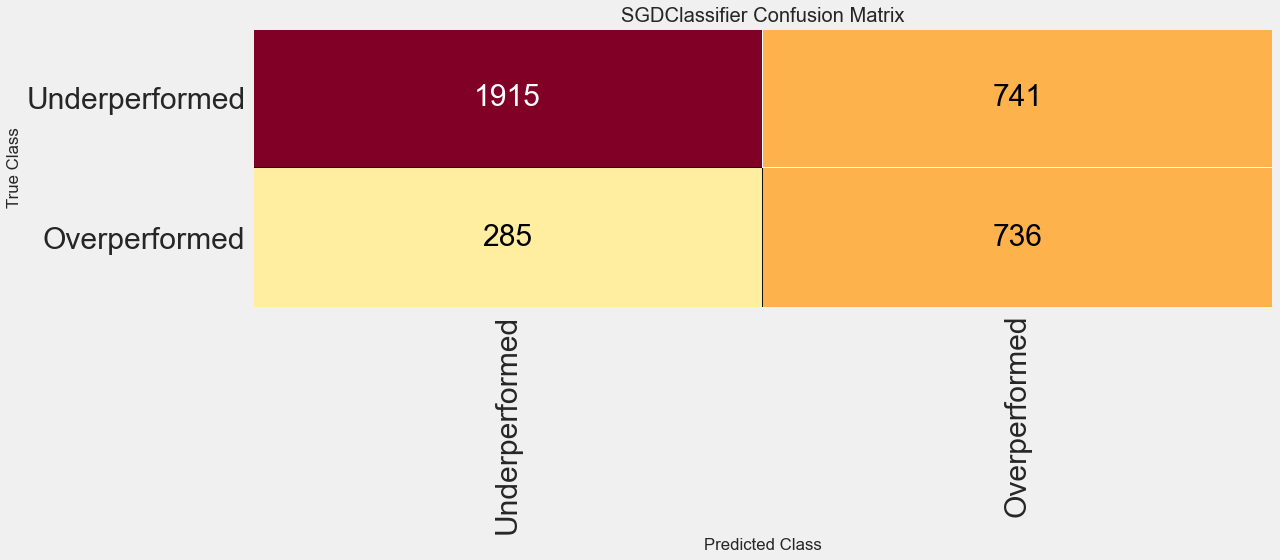

<AxesSubplot:title={'center':'SGDClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [308]:
model = SGDClassifier(
    class_weight = 'balanced',
    loss = 'hinge',
    max_iter = 500,
    n_jobs = -1,
    penalty = 'l1'
)

cm = ConfusionMatrix(
    model,
    classes = ['Underperformed', 'Overperformed'],
    fontsize = 30
)

cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.show()

[return to top](#header_cell)
### Time Series Split Cross Validation
<a id='time_series_split_cv'></a>
Finally, I'll perform a time series split cross validation to check the mean and standard deviation for each week's data

In [309]:
X_cv = preprocessor.fit_transform(X)
y_cv = LabelEncoder().fit_transform(y)

X_cv = pd.DataFrame(X_cv)
y_cv = pd.DataFrame(y_cv)

In [310]:
for n in range(1,18):
    
    print(f'Cross-validating fold {n}')
    # prepare the cross-validation procedure
    cv = KFold(
        n_splits = n+1,
        random_state = 123,
        shuffle = True
    )
    # create model
    model = SGDClassifier(
        class_weight = 'balanced',
        loss = 'hinge',
        max_iter = 500,
        n_jobs = -1,
        penalty = 'l1'
    )
    # evaluate model
    scores = cross_val_score(
        model,
        X_cv[:(X[X['Week'] <= n].index.to_list()[-1] + 1)],
        y_cv[:(X[X['Week'] <= n].index.to_list()[-1] + 1)],
        scoring = 'accuracy',
        cv = cv,
        n_jobs = -1
    )
    # report performance
    means = []
    means.append(mean(scores))
    print(
        f'Accuracy: Mean: {mean(scores)}, stdev: {std(scores)}'
        '\n'
    )
print(f'Mean of mean scores: {sum(means) / len(means)}')

Cross-validating fold 1
Accuracy: Mean: 0.6666666666666667, stdev: 0.03198653198653195

Cross-validating fold 2
Accuracy: Mean: 0.651553316540722, stdev: 0.05795579988189872

Cross-validating fold 3
Accuracy: Mean: 0.6525705662878694, stdev: 0.047064328209061895

Cross-validating fold 4
Accuracy: Mean: 0.6762006403415155, stdev: 0.03238915776546209

Cross-validating fold 5
Accuracy: Mean: 0.6798886569241476, stdev: 0.04079299651545211

Cross-validating fold 6
Accuracy: Mean: 0.7083946980854198, stdev: 0.010874471247113255

Cross-validating fold 7
Accuracy: Mean: 0.711420401018526, stdev: 0.015339233876601991

Cross-validating fold 8
Accuracy: Mean: 0.7203771089072133, stdev: 0.009678698714132636

Cross-validating fold 9
Accuracy: Mean: 0.722204799095881, stdev: 0.01445799774904375

Cross-validating fold 10
Accuracy: Mean: 0.7254412012964778, stdev: 0.009958377224798419

Cross-validating fold 11
Accuracy: Mean: 0.7288599623928965, stdev: 0.012743104465615848

Cross-validating fold 12
Ac

Finally, I'll look at the data now that it is scaled for presentation purposes

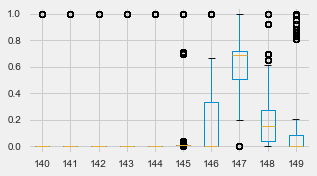

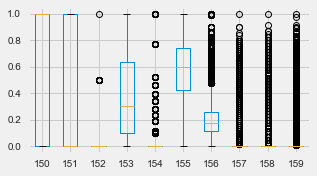

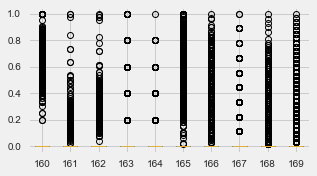

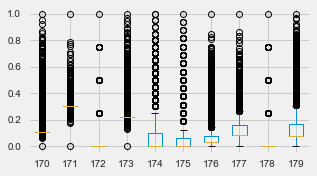

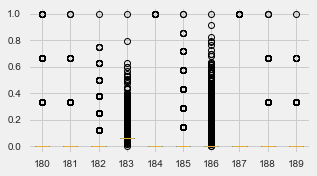

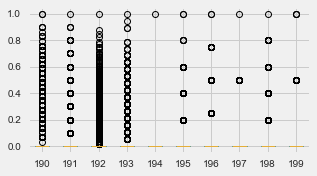

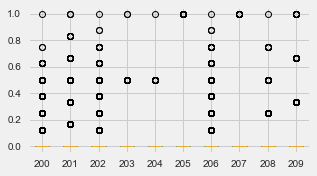

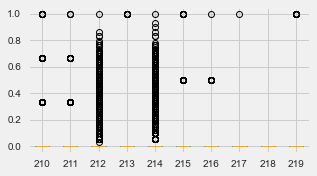

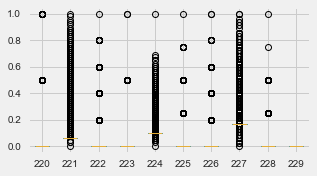

<Figure size 324x180 with 0 Axes>

In [311]:
for n in range(0,89,10):
    plt.rcParams['figure.figsize'] = (4.5,2.5)
    plt.style.use('fivethirtyeight')
    X_train_df.loc[:,140+n:149+n].boxplot()
    plt.savefig(
        f'../../../fixtures/images/presentation_screenshots/post-scaling/Global_columns{140+n}To{149+n}_BoxPlot.png',
        bbox_inches='tight'
    )
    plt.show()
    plt.clf()

[reurn to top](#header_cell)
### Pickling the Model for Future Use
<a id='pickling_cell'></a>

In [312]:
filename = '../../../foo/global_model.sav'
pickle.dump(model, open(filename, 'wb'))